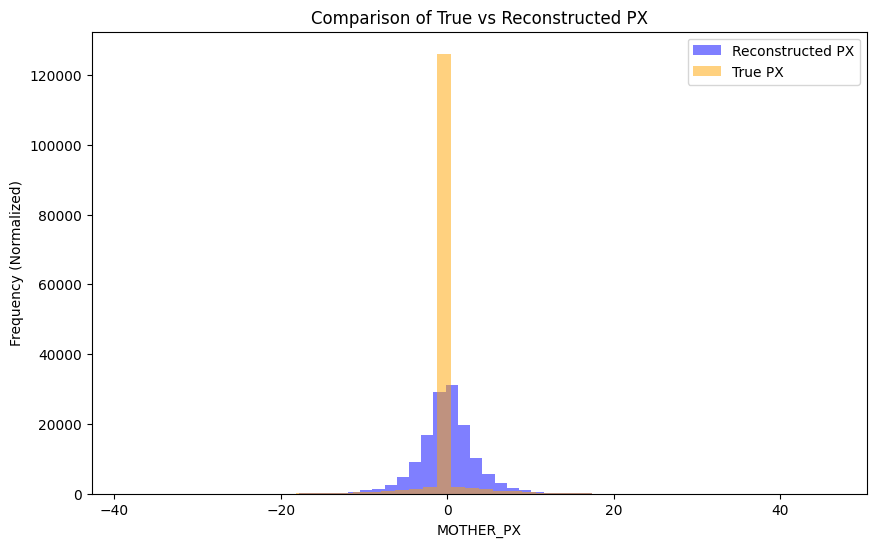

In [29]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

# Open ROOT files and read branches
true_file = uproot.open("~/fast_vertexing_variables/datasets/combinatorial_select_Kuu.root" )
reco_file = uproot.open("~/fast_vertexing_variables/datasets/combinatorial_select_Kuu_inferable_reco_D.root" )["DecayTree"]


# Extract relevant branches for comparison
reco_data = reco_file["DecayTree"].arrays(["MOTHER_PX", "MOTHER_PX_TRUE", "MOTHER_vtxX", "MOTHER_vtxX_TRUE"], library="np")
true_data = true_file["DecayTree"].arrays(["MOTHER_PX", "MOTHER_TRUEP_X", "MOTHER_ENDVERTEX_X", "MOTHER_TRUEORIGINVERTEX_X"], library="np")

# Extract arrays
reco_px = reco_data["MOTHER_PX"]
true_px = reco_data["MOTHER_PX_TRUE"]
reco_vtxX = reco_data["MOTHER_vtxX"]
true_vtxX = reco_data["MOTHER_vtxX_TRUE"]

# Plot signal comparison: True vs Reconstructed MOTHER_PX
plt.figure(figsize=(10, 6))
plt.hist(reco_px, bins=50, alpha=0.5, label="Reconstructed PX", color='blue')
plt.hist(true_px, bins=50, alpha=0.5, label="True PX", color='orange')
plt.xlabel("MOTHER_PX")
plt.ylabel("Frequency (Normalized)")
plt.title("Comparison of True vs Reconstructed PX")
plt.legend()
plt.show()


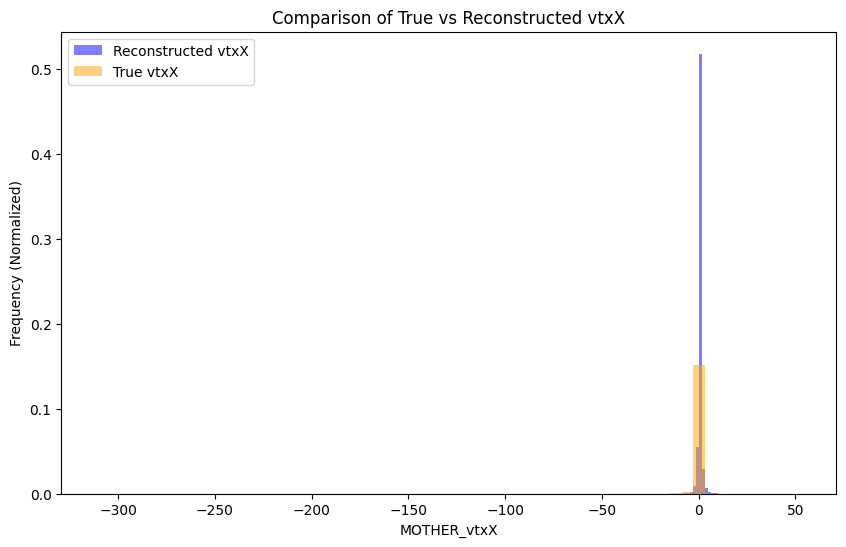

In [27]:

# Comparison for vertex positions (MOTHER_vtxX)
plt.figure(figsize=(10, 6))
plt.hist(reco_vtxX, bins=50, alpha=0.5, label="Reconstructed vtxX", color='blue', density=True)
plt.hist(true_vtxX, bins=50, alpha=0.5, label="True vtxX", color='orange', density=True)
plt.xlabel("MOTHER_vtxX")
plt.ylabel("Frequency (Normalized)")
plt.title("Comparison of True vs Reconstructed vtxX")
plt.legend()
plt.show()


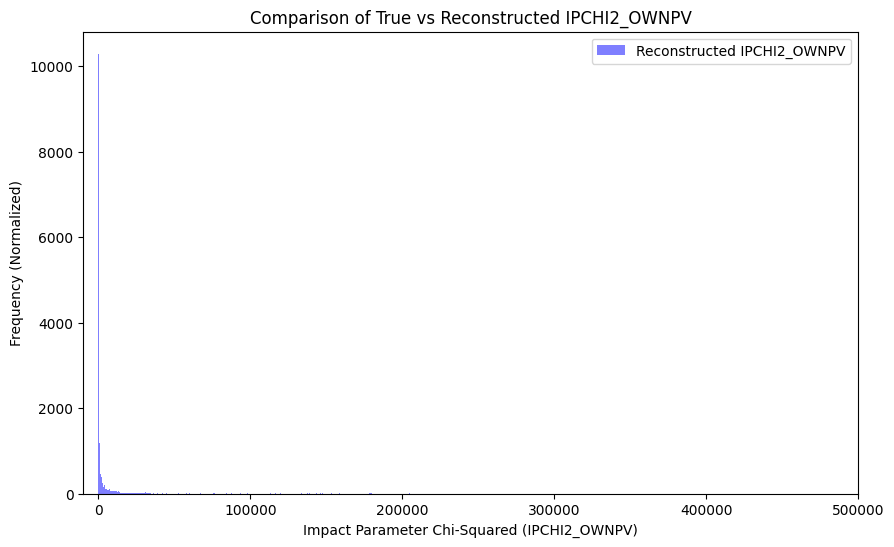

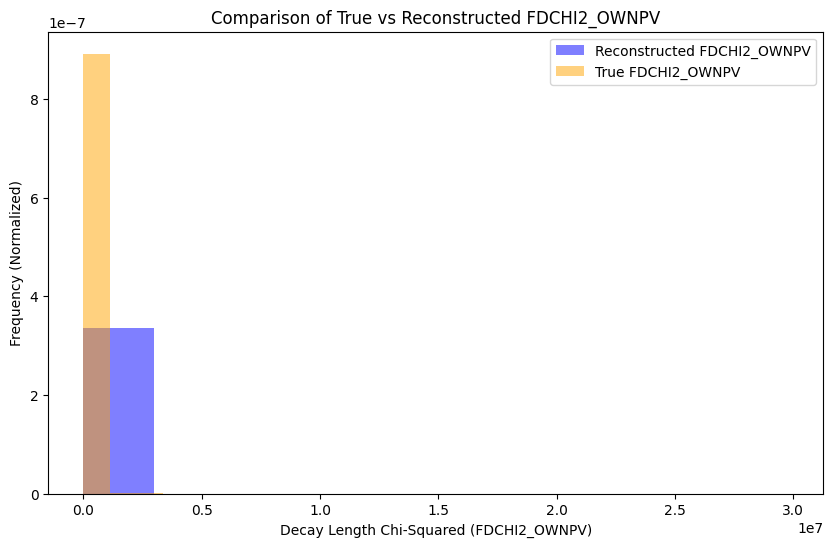

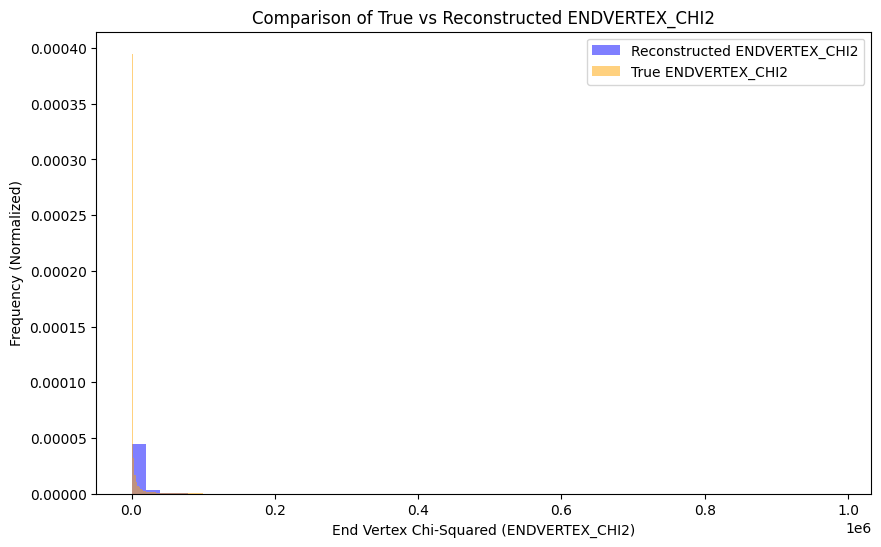

/home/viola/anaconda3/envs/fast_vtx/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [16:30:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


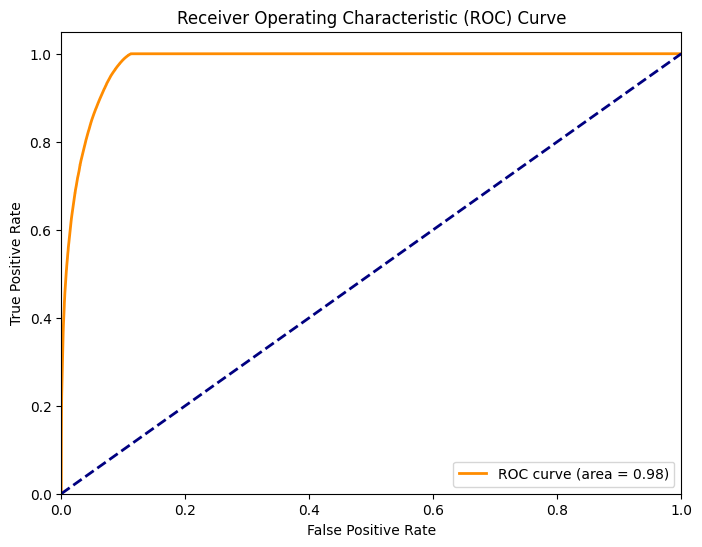

ValueError: autodetected range of [nan, nan] is not finite

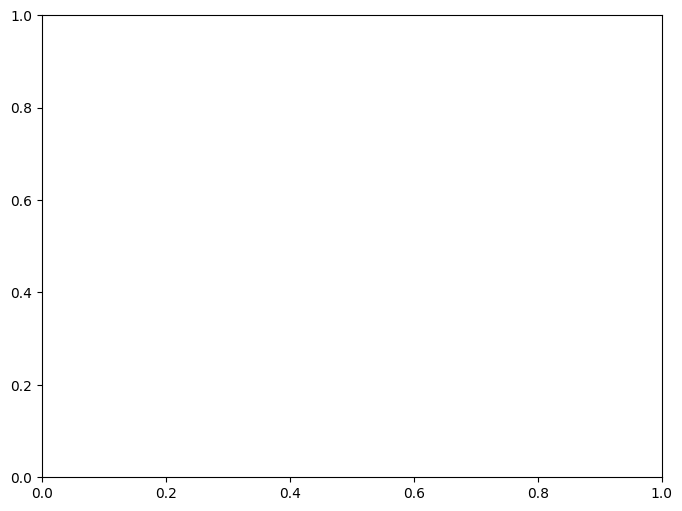

In [45]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import xgboost as xgb

# Load the reconstructed and true ROOT files
true_file = uproot.open("~/fast_vertexing_variables/datasets/combinatorial_select_Kuu.root" )
reco_file = uproot.open("~/fast_vertexing_variables/datasets/combinatorial_select_Kuu_inferable_reco_D.root" )

# Extract higher-level quantities from both files
reco_data = reco_file["DecayTree"].arrays(["MOTHER_IPCHI2_OWNPV", "MOTHER_FDCHI2_OWNPV", "MOTHER_ENDVERTEX_CHI2"], library="np")
true_data = true_file["DecayTree"].arrays(["MOTHER_IPCHI2_OWNPV", "MOTHER_FDCHI2_OWNPV", "MOTHER_ENDVERTEX_CHI2"], library="np")

# Extract arrays for comparison
reco_ipchi2 = reco_data["MOTHER_IPCHI2_OWNPV"]
reco_fdchi2 = reco_data["MOTHER_FDCHI2_OWNPV"]
reco_vertex_chi2 = reco_data["MOTHER_ENDVERTEX_CHI2"]

true_ipchi2 = true_data["MOTHER_IPCHI2_OWNPV"]
true_fdchi2 = true_data["MOTHER_FDCHI2_OWNPV"]
true_vertex_chi2 = true_data["MOTHER_ENDVERTEX_CHI2"]

# Plot comparison for Impact Parameter Chi-Squared (IPCHI2_OWNPV)
plt.figure(figsize=(10, 6))
plt.hist(reco_ipchi2, bins=500, alpha=0.5, label="Reconstructed IPCHI2_OWNPV", color='blue')
#plt.hist(true_ipchi2, bins=500, alpha=0.5, label="True IPCHI2_OWNPV", color='orange', density=True)
plt.xlim([-10000, 500000])
plt.xlabel("Impact Parameter Chi-Squared (IPCHI2_OWNPV)")
plt.ylabel("Frequency (Normalized)")
plt.title("Comparison of True vs Reconstructed IPCHI2_OWNPV")
plt.legend()
plt.show()

# Plot comparison for Decay Length Chi-Squared (FDCHI2_OWNPV)
plt.figure(figsize=(10, 6))
plt.hist(reco_fdchi2, alpha=0.5, label="Reconstructed FDCHI2_OWNPV", color='blue', density=True)
plt.hist(true_fdchi2, alpha=0.5, label="True FDCHI2_OWNPV", color='orange', density=True)

plt.xlabel("Decay Length Chi-Squared (FDCHI2_OWNPV)")
plt.ylabel("Frequency (Normalized)")
plt.title("Comparison of True vs Reconstructed FDCHI2_OWNPV")
plt.legend()
plt.show()

# Plot comparison for Vertex Quality Chi-Squared (ENDVERTEX_CHI2)
plt.figure(figsize=(10, 6))
plt.hist(reco_vertex_chi2, bins=50, alpha=0.5, label="Reconstructed ENDVERTEX_CHI2", color='blue', density=True)
plt.hist(true_vertex_chi2, bins=50, alpha=0.5, label="True ENDVERTEX_CHI2", color='orange', density=True)
plt.xlabel("End Vertex Chi-Squared (ENDVERTEX_CHI2)")
plt.ylabel("Frequency (Normalized)")
plt.title("Comparison of True vs Reconstructed ENDVERTEX_CHI2")
plt.legend()
plt.show()

# BDT model to validate the reconstructed data against the true data

# Prepare dataset for BDT: Use a combination of IPCHI2 and FDCHI2 for classification
X_reco = np.vstack((reco_ipchi2, reco_fdchi2)).T
X_true = np.vstack((true_ipchi2, true_fdchi2)).T

# Create labels for training: 1 for true, 0 for reconstructed
y_reco = np.zeros(len(reco_ipchi2))
y_true = np.ones(len(true_ipchi2))

# Concatenate data for BDT training
X = np.concatenate([X_reco, X_true])
y = np.concatenate([y_reco, y_true])

# Train a simple BDT
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss")
model.fit(X, y)

# Predict probabilities on the same data
y_pred = model.predict_proba(X)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y, y_pred)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# 2D Histogram of IPCHI2 and FDCHI2 (based on BDT classification)
plt.figure(figsize=(8, 6))
plt.hist2d(reco_ipchi2, reco_fdchi2, bins=50, cmap='Blues', density=True)
plt.colorbar(label='Density')
plt.xlabel("Reconstructed IPCHI2_OWNPV")
plt.ylabel("Reconstructed FDCHI2_OWNPV")
plt.title("2D Histogram of Reconstructed IPCHI2 vs FDCHI2")
plt.show()


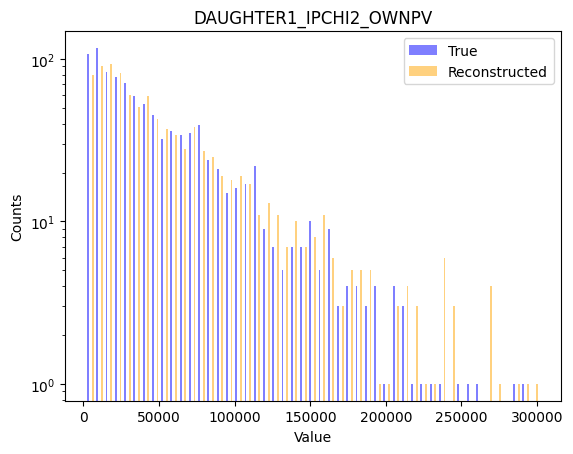

In [52]:


bins = np.linspace(0, 300000, 50) 


plt.hist(df['Real'], bins=bins, alpha=0.5, label='True', color='blue', log=True, rwidth=0.2)
plt.hist(df['Reco'], bins=bins + (bins[1] - bins[0]) / 2, alpha=0.5, label='Reconstructed', color='orange', rwidth=0.2)


plt.title("DAUGHTER1_IPCHI2_OWNPV")
plt.xlabel('Value')
plt.ylabel('Counts')
plt.legend()

plt.show()

